In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as pl

import sklearn as sk
import pandas as pd
import numpy as np
import pathlib as pl

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import zero_one_loss, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from collections import Counter

import os
import sys
os.chdir("D:\OneDrive\OneDrive - UW-Madison\Kris\Code\curatedMetagenomicDataAnalyses\\vignettes")
# os.chdir("C:\OneDrive\OneDrive - UW-Madison\Kris\Code\curatedMetagenomicDataAnalyses\\vignettes")
import gc

# visualizations
import plotly.express as px
import plotly.offline as pyo
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

custom_colors = ["#a8e6cf","#dcedc1","#ffd3b6","#ffaaa5","#ff8b94"]
palette = sns.set_palette(sns.color_palette(custom_colors))
FP_CRC_META = os.path.join("crc_meta.csv")
FP_CRC_SEPARATE = os.path.join("crc_separate_taxon.csv")
FP_CRC_WHOLE = os.path.join("crc_whole_taxon.csv")
FP_CRC_MAT = os.path.join("crc_mat.csv")
FP_DIFF_FZ = os.path.join(".\\processed\\diff_FZ.csv")

In [2]:
crc_meta = pd.read_csv(FP_CRC_META)
na_indices = np.where(crc_meta.study_condition.isna())[0]
crc_meta = crc_meta.drop(na_indices)
# crc_sepa = pd.read_csv(FP_CRC_SEPARATE)
crc_whole = pd.read_csv(FP_CRC_WHOLE)
crc_whole = crc_whole.drop(na_indices)
diff_FZ = pd.read_csv(FP_DIFF_FZ)
# crc_whole = crc_whole.fillna(0)

# crc_data = crc_sepa.iloc[7:, 3:]
# crc_data = crc_data.astype(float)

# crc_sepa.rename(columns={'Unnamed: 0': 'observations'}, inplace=True)
study_names = np.unique(crc_whole.study_name)

In [8]:
Counter(crc_whole.study_name)

Counter({'FengQ_2015': 154,
         'GuptaA_2019': 60,
         'HanniganGD_2017': 81,
         'ThomasAM_2018a': 80,
         'ThomasAM_2018b': 60,
         'ThomasAM_2019_c': 80,
         'VogtmannE_2016': 104,
         'WirbelJ_2018': 125,
         'YachidaS_2019': 616,
         'YuJ_2015': 128,
         'ZellerG_2014': 156})

In [44]:
crc_whole

,observations,study_name,study_condition,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_salivarius,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_hadrus,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_stercoris,k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_aerofaciens,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_longum,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_plebeius,...,k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Candida|s__Candida_tropicalis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_hellenica,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus,k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_coli,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_striatum,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_pseudodiphtheriticum,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_crustorum,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_farciminis,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_quasivariicola,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_massiliense
0,SID31004,FengQ_2015,CRC,5557520,4501905,3379283,2134734,1875111,1600270,1543442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SID31009,FengQ_2015,control,3426422,91870,4992315,0,2436224,1566408,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SID31021,FengQ_2015,control,3703353,106369,5022513,7228,1626225,2537241,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SID31030,FengQ_2015,adenoma,1407572,78931,540874,300730,1104594,491720,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SID31071,FengQ_2015,control,6735145,136315,1595369,33915,4128586,3397989,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,CCIS95409808ST.4.0,ZellerG_2014,control,1021983,186876,643569,32664,1199899,793182,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7950.0
1646,CCIS96387239ST.4.0,ZellerG_2014,adenoma,2306131,22790,21378,327276,781411,397046,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1647,CCIS98482370ST.3.0,ZellerG_2014,control,1795756,6503,701544,3724477,20806,12635,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1648,CCIS98512455ST.4.0,ZellerG_2014,CRC,1615860,191933,328142,2138003,90401,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
crc_whole_FZ = crc_whole[crc_whole['study_name'].isin(['FengQ_2015', 'ZellerG_2014'])]

In [16]:
Counter(crc_whole[crc_whole['study_name'].isin([study_names[0]])].study_condition)

Counter({'CRC': 46, 'control': 61, 'adenoma': 47})

In [22]:
Counter(crc_whole[crc_whole['study_name'].isin([study_names[10]])].study_condition)

Counter({'control': 61, 'CRC': 53, 'adenoma': 42})

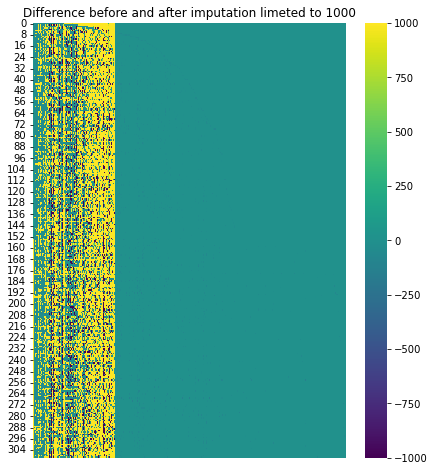

In [4]:
plt.figure(figsize=(7, 8))
sns.heatmap(diff_FZ, cmap='viridis', cbar=True, annot=False, vmax = 1000, vmin=-1000, xticklabels=False)
plt.title('Difference before and after imputation limeted to 1000')
plt.show()

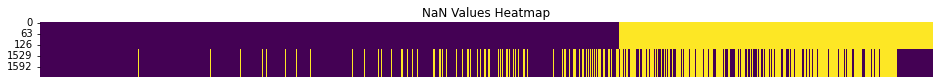

In [33]:
plt.figure(figsize=(16, 1))
sns.heatmap(crc_whole_FZ.isnull(), cmap='viridis', cbar=False, xticklabels=False)
plt.title('NaN Values Heatmap')
plt.show()

In [36]:
crc_whole_FZ_intersect = crc_whole_FZ.dropna(axis=1, inplace=False)

In [39]:
crc_whole_FZ.shape

(310, 938)

In [48]:
crc_meta_FZ = crc_meta[crc_meta['study_name'].isin(['FengQ_2015', 'ZellerG_2014'])]
crc_meta_FZ

,observations,study_name,study_condition
0,SID31004,FengQ_2015,CRC
1,SID31009,FengQ_2015,control
2,SID31021,FengQ_2015,control
3,SID31030,FengQ_2015,adenoma
4,SID31071,FengQ_2015,control
...,...,...,...
1645,CCIS95409808ST.4.0,ZellerG_2014,control
1646,CCIS96387239ST.4.0,ZellerG_2014,adenoma
1647,CCIS98482370ST.3.0,ZellerG_2014,control
1648,CCIS98512455ST.4.0,ZellerG_2014,CRC


In [49]:
crc_meta_FZ.to_csv('crc_meta_FZ.csv')
crc_whole_FZ.to_csv('crc_whole_FZ.csv')
crc_whole_FZ_intersect.to_csv('crc_whole_FZ_intersect.csv')

# Visualize H matrix

In [64]:
train_names = np.delete(study_names, 1)
Hnorm = pd.read_csv("hnorm.csv")
mask = crc_whole.study_name==study_names[1]
Hnorm.loc[:, Hnorm.columns[0]] = crc_whole.study_name[~mask]

Hnorm = Hnorm.rename(columns={Hnorm.columns[0]:"study_name"})
Hnorm
# Hnorm.drop([Hnorm.columns[0]], axis=1, inplace=True)

,study_name,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,FengQ_2015,9.832695,50.741004,0.109486,2.887188,164.262882,0.000000,3.169734,0.000000,0.816551,...,0.000000,0.000000,13.992879,9.749450,1.052023,4.004893,0.000000,0.125156,0.000000,0.000000
1,FengQ_2015,4.665497,2.891011,0.066680,0.616176,32.589195,16.969342,7.823883,0.657130,0.414065,...,2.089016,0.053542,3.854009,0.000000,0.921041,2.900524,9.499558,0.928075,4.950202,0.182929
2,FengQ_2015,7.576028,5.451625,0.425516,2.604099,23.387192,1.689833,2.252629,1.122063,1.084546,...,10.909677,0.093202,10.067161,5.969785,0.440610,1.510190,0.000000,0.208127,26.711561,0.186438
3,FengQ_2015,23.732982,14.035440,0.000000,0.000000,0.000000,12.972928,2.631804,0.161509,3.959473,...,11.220215,0.043631,0.000000,1.868204,0.118505,9.979254,8.581715,0.097387,10.801088,0.133697
4,FengQ_2015,30.849342,2.092437,1.281230,5.412406,115.147865,1.498001,0.000000,0.229379,0.982766,...,131.827262,0.094525,6.874929,0.000000,0.260998,0.000000,7.414416,0.149129,2.004643,0.099980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1579,ZellerG_2014,37.770366,0.000000,1.694400,6.077545,15.232847,65.725493,1.035162,4.404143,45.155234,...,0.151055,0.855700,0.000000,0.133647,0.291863,0.000000,0.000000,0.325068,4.170474,12.664948
1580,ZellerG_2014,0.000000,0.000000,53.373506,0.000000,0.000000,12.107250,2.325808,2.033840,15.563097,...,0.000000,0.000000,3.156828,0.425557,0.228720,0.000000,0.647159,0.000000,0.843778,0.784377
1581,ZellerG_2014,0.000000,6.640516,15.720937,27.615552,4.033426,66.390194,0.720191,1.180165,0.000000,...,0.075902,1.096447,0.158143,0.709588,0.262863,0.000000,5.422666,0.177321,0.000000,0.000000
1582,ZellerG_2014,3.613534,5.179985,5.651467,7.854753,40.608930,67.266661,2.751342,0.566261,0.000000,...,0.000000,0.000000,0.000000,0.379791,0.000000,17.436179,2.622739,0.521998,0.000000,6.276975


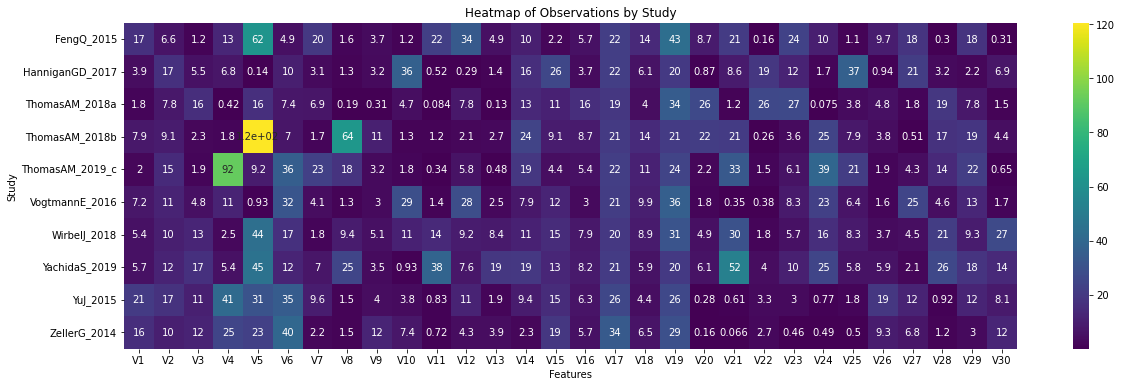

In [70]:
grouped_data = Hnorm.groupby('study_name').mean()  # You can use other aggregation functions if needed

# Create a heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(grouped_data, annot=True, cmap='viridis')

# Customize the plot
plt.title('Heatmap of Observations by Study')
plt.xlabel('Features')
plt.ylabel('Study')

# Show the plot
plt.show()

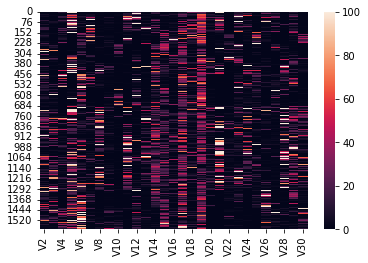

In [20]:
sns.heatmap(Hnorm.iloc[:, 1:], vmax=100)

# Display the heatmap
plt.show()

In [73]:
response_mask = crc_whole.iloc[:,2].isin([0, 'carcinoma_surgery_history'])

# Apply the mask to the DataFrame to keep rows that don't match the categories
crc_whole = crc_whole[~response_mask]

y_mapping = {
    "control": 0,
    "CRC": 1,
    "adenoma": 2
}

crc_whole.iloc[:,2] = [y_mapping[item] for item in crc_whole.iloc[:,2]]

In [74]:
# Number of observations per study
Counter(crc_whole.iloc[:,1])

Counter({'FengQ_2015': 154,
         'GuptaA_2019': 60,
         'HanniganGD_2017': 81,
         'ThomasAM_2018a': 80,
         'ThomasAM_2018b': 60,
         'ThomasAM_2019_c': 80,
         'VogtmannE_2016': 104,
         'WirbelJ_2018': 125,
         'YachidaS_2019': 576,
         'YuJ_2015': 128,
         'ZellerG_2014': 156})

In [75]:
# Count of responses
Counter(crc_whole.iloc[:,2])

Counter({1: 701, 0: 694, 2: 209})

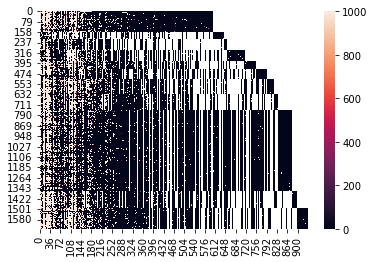

In [5]:
sns.heatmap(X, vmax=1000)

# Display the heatmap
plt.show()

In [76]:
study_test = [study_names[1]]
study_train = [study for study in study_names if study not in study_test]
print(study_test)
print(study_train)

['GuptaA_2019']
['FengQ_2015', 'HanniganGD_2017', 'ThomasAM_2018a', 'ThomasAM_2018b', 'ThomasAM_2019_c', 'VogtmannE_2016', 'WirbelJ_2018', 'YachidaS_2019', 'YuJ_2015', 'ZellerG_2014']


In [77]:
data_train = crc_whole[crc_whole['study_name'].isin(study_train)]
data_test = crc_whole[crc_whole['study_name'].isin(study_test)]

In [99]:
X_train = data_train.iloc[:, 3:].values
X_test = data_test.iloc[:, 3:].values
# y_train = data_train.iloc[:, 2] == "CRC"
# y_test = data_test.iloc[:, 2] == "CRC"
y_train = data_train.iloc[:, 2]
y_test = data_test.iloc[:, 2]

In [100]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1544, 935)
(60, 935)
(1544,)
(60,)


In [101]:
# Run PCA
p = 100

X_train_sd = StandardScaler().fit_transform(X_train)
pca_train = PCA(n_components=p)
X_train_pca = pca_train.fit_transform(X_train_sd)

In [92]:
X_test_sd.shape

(60, 100)

In [112]:
Counter(y_test)

Counter({1: 30, 0: 30})

In [142]:
# Logstic
# model = LogisticRegression(multi_class='multinomial')
# model = RandomForestClassifier()
model = KNeighborsClassifier()
model.fit(X_train_pca, y_train)

X_test_sd = StandardScaler().fit_transform(X_test)
X_test_pca = pca_train.transform(X_test_sd)
y_pred = model.predict(X_test_pca)


In [139]:
y_pred

array([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [130]:
y_test.values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [131]:
class_report = classification_report(y_test, y_pred)
print("LogisticRegression Report:\n", class_report)

LogisticRegression Report:
               precision    recall  f1-score   support

           0       0.79      0.87      0.83        30
           1       0.88      0.77      0.82        30
           2       0.00      0.00      0.00         0

    accuracy                           0.82        60
   macro avg       0.56      0.54      0.55        60
weighted avg       0.84      0.82      0.82        60



d:\Anaconda\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

d:\Anaconda\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

d:\Anaconda\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [144]:
conf_matrix = confusion_matrix(y_test, y_pred)
# df_conf_matrix = pd.DataFrame(conf_matrix, index=['True 0', 'True 1'], columns=['Predicted 0', 'Predicted 1'])
df_conf_matrix = pd.DataFrame(conf_matrix, index=['True 0', 'True 1', 'True 2'], columns=['Predicted 0', 'Predicted 1', 'Predicted 2'])
print(df_conf_matrix)

        Predicted 0  Predicted 1  Predicted 2
True 0           27            3            0
True 1           11           16            3
True 2            0            0            0


## cFIT

In [148]:
with open('cFIT_pred.txt', 'r') as file:
    cFIT_pred = file.read().splitlines()
with open('cFIT_test.txt', 'r') as file:
    cFIT_test = file.read().splitlines()

In [151]:
class_report = classification_report(cFIT_test, cFIT_pred)
print("cFIT Report:\n", class_report)

cFIT Report:
               precision    recall  f1-score   support

         CRC       1.00      0.50      0.67        30
     adenoma       0.00      0.00      0.00         0
     control       0.65      0.87      0.74        30

    accuracy                           0.68        60
   macro avg       0.55      0.46      0.47        60
weighted avg       0.82      0.68      0.70        60



d:\Anaconda\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

d:\Anaconda\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

d:\Anaconda\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



In [153]:
conf_matrix = confusion_matrix(cFIT_test, cFIT_pred)
# df_conf_matrix = pd.DataFrame(conf_matrix, index=['True 0', 'True 1'], columns=['Predicted 0', 'Predicted 1'])
df_conf_matrix = pd.DataFrame(conf_matrix, index=['CRC', 'Adenoma', 'Control'], columns=['CRC', 'Adenoma', 'Control'])
print(df_conf_matrix)

         CRC  Adenoma  Control
CRC       15        1       14
Adenoma    0        0        0
Control    0        4       26


In [149]:
cFIT_test

['CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'control',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC',
 'CRC']